In [1]:
#Author     : Fan Li
#Update Date: 04/10/2022
#Version    : 3.0

#Intrusion Detection System Using Machine Learning (Random Forest)

#Original Data (cic ids 2017)

#hardware
#12vCPUs | 48GiB | c7.3xlarge.4

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics

#over-sampling and under sampling
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

#time
from time import time
import datetime

In [3]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [4]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [5]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [7]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN          2273097
DoS              380688
PortScan         158930
BruteForce        13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [8]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

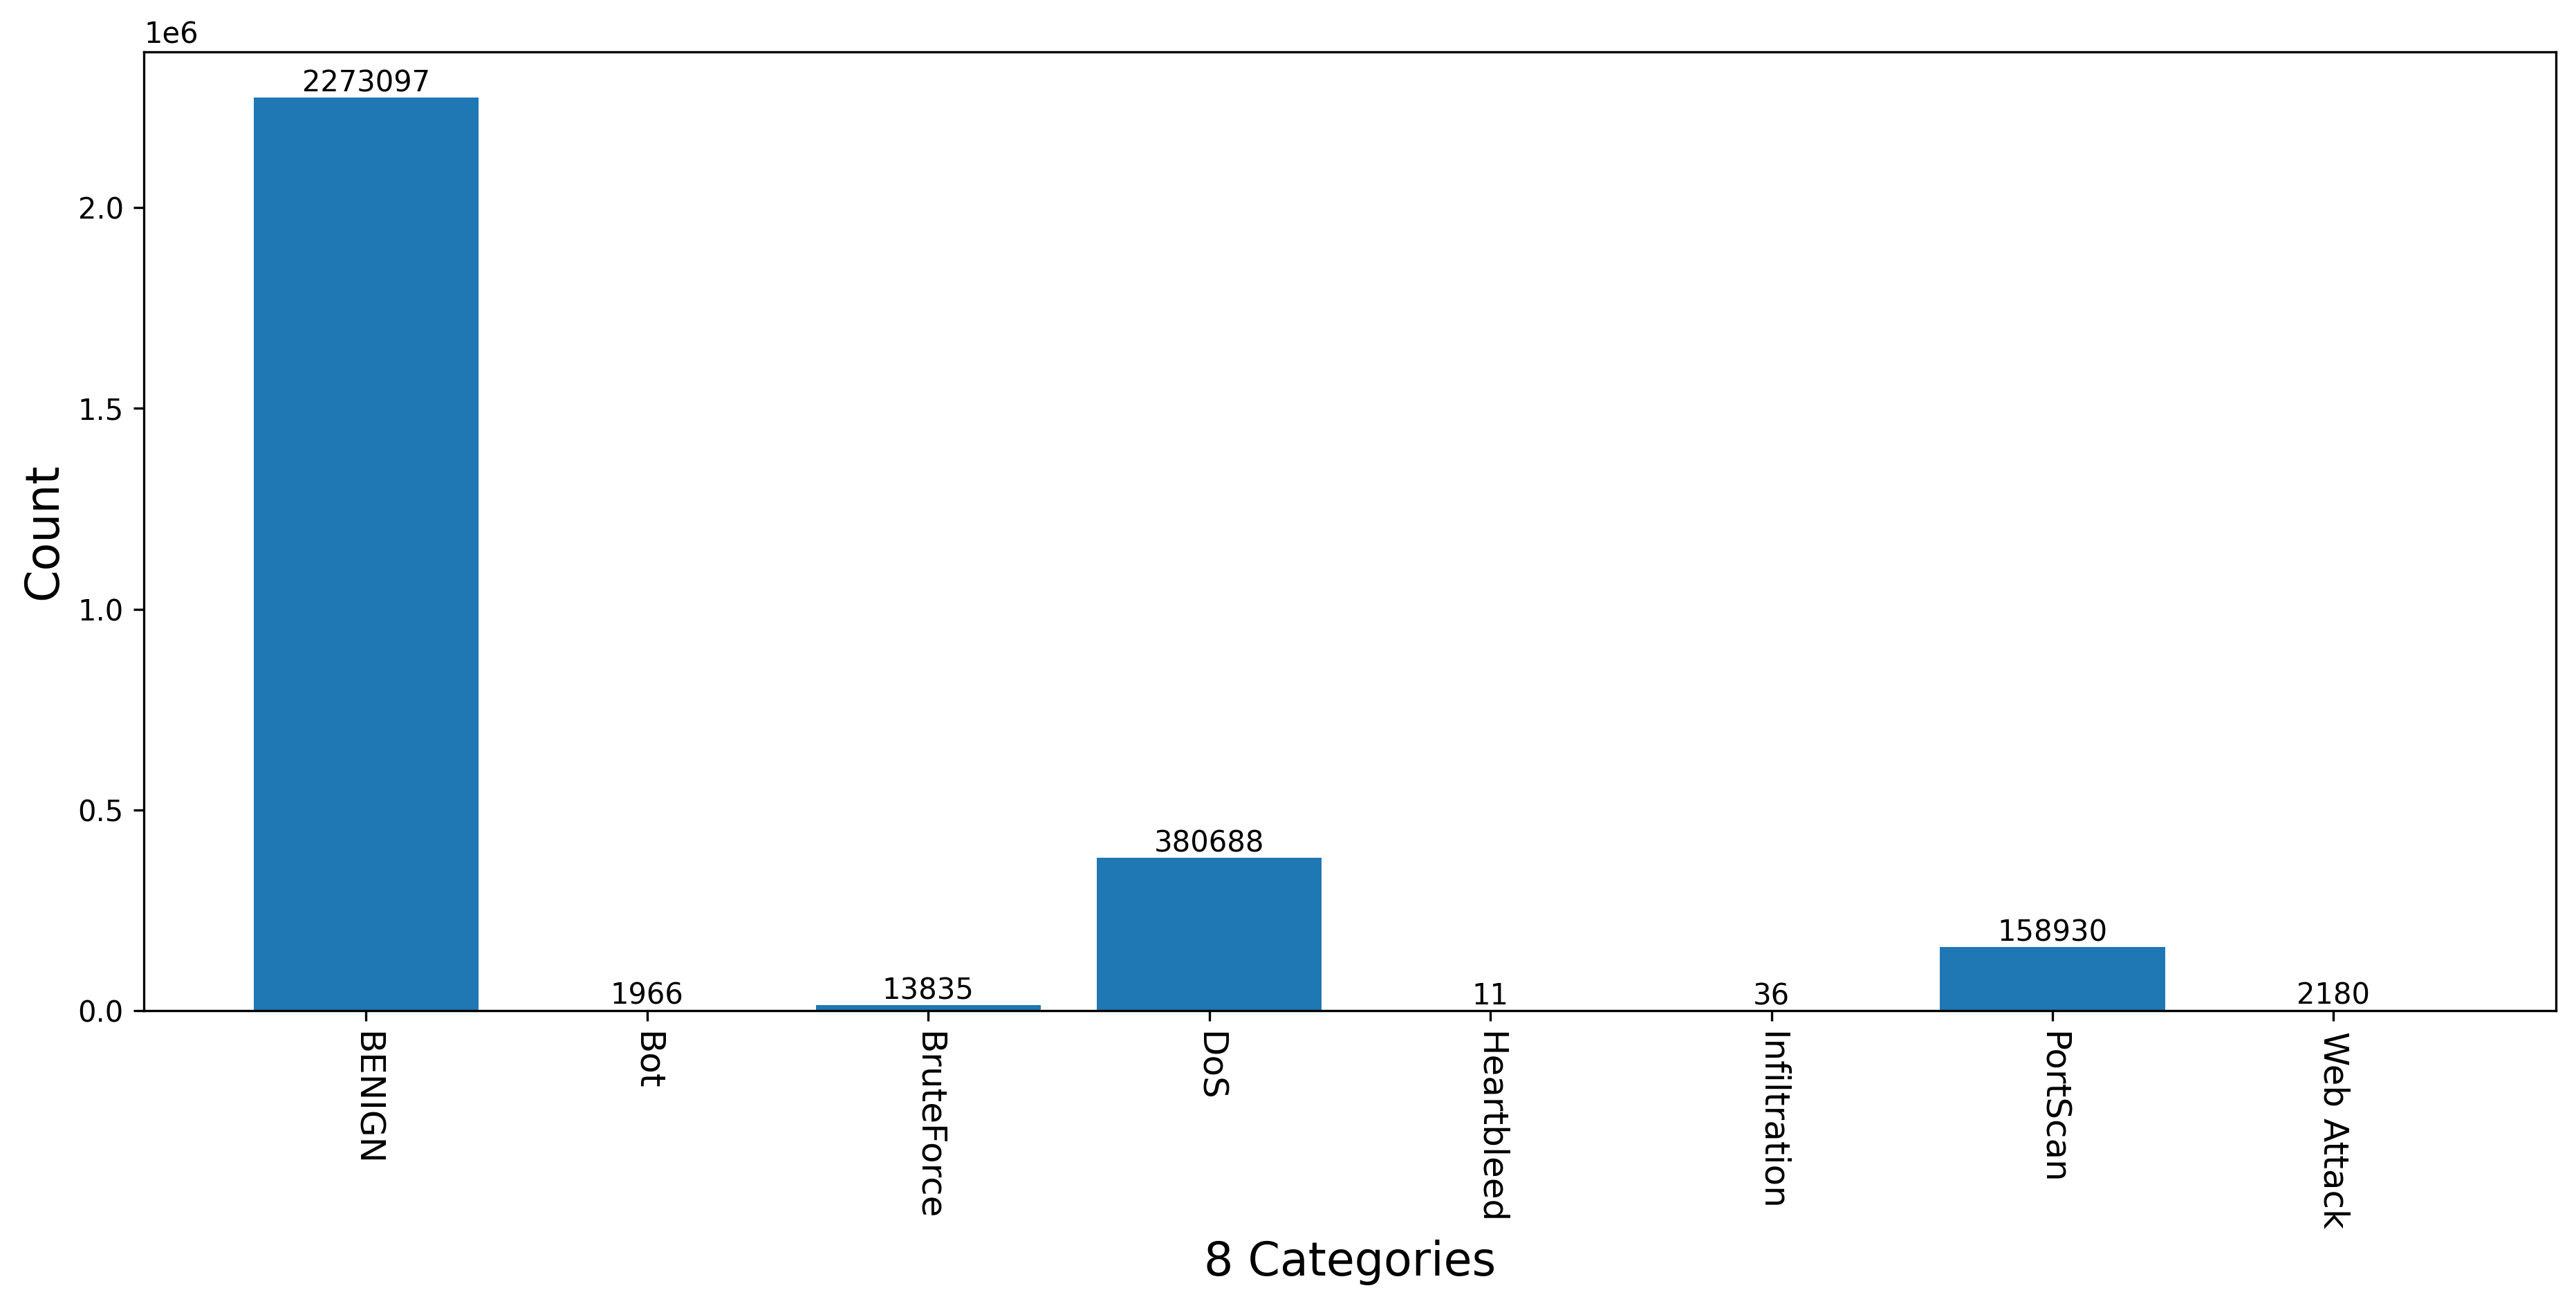

In [9]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [10]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [11]:
data[' Label'].value_counts()

BENIGN          2072476
DoS              321759
PortScan          90694
BruteForce         9150
Web Attack         2143
Bot                1948
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [12]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS': 321759, 'PortScan': 90694, 'BruteForce': 9150, 'Web Attack': 2143, 'Bot': 1948, 'Infiltration': 36, 'Heartbleed': 11})


In [13]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 3: 321759, 6: 90694, 2: 9150, 7: 2143, 1: 1948, 5: 36, 4: 11})


In [14]:
#Ram Clean
del data
gc.collect()

3692

In [15]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33,random_state=123456)

In [16]:
print(Counter(y_train))

Counter({0: 1388615, 3: 215467, 6: 60860, 2: 6100, 7: 1440, 1: 1293, 5: 20, 4: 10})


In [ ]:
#3.3 SMOTE
time0=time()

#sm=SMOTE(k_neighbors=9,random_state=42,n_jobs=-1)
#X_train,y_train=sm.fit_resample(X_train,y_train)

smote_tomek = SMOTETomek(random_state=42,n_jobs=-1)
X_train,y_train=smote_tomek.fit_resample(X_train,y_train)

In [ ]:
print("Time of SMOTE : {:.3f} s".format(time()-time0))

In [34]:
print(Counter(y_train))

Counter({4: 1388615, 5: 1388615, 1: 1388583, 2: 1388538, 7: 1388499, 3: 1388175, 6: 1388173, 0: 1387760})


In [109]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((11106958, 78), (11106958,), (824412, 78), (824412,))

In [110]:
y_train_pd=pd.DataFrame(y_train,columns=[' Label'])

In [111]:
y_test_pd=pd.DataFrame(y_test,columns=[' Label'])

In [112]:
data_train=pd.concat((X_train,y_train_pd),axis=1)

In [113]:
X_test.shape,y_test_pd.shape

((824412, 78), (824412, 1))

In [115]:
X_test.to_csv("X_test.csv")

In [116]:
y_test_pd.to_csv("y_test.csv")

In [117]:
data_train.shape

(11106958, 79)

In [118]:
data_train.to_csv("data_train.csv")

In [119]:
target_count_smote=data_train[' Label'].value_counts()
target_count_smote

4    1388615
5    1388615
1    1388583
2    1388538
7    1388499
3    1388175
6    1388173
0    1387760
Name:  Label, dtype: int64

In [120]:
labels_smote,values_smote=zip(*sorted(target_count_smote.items()))

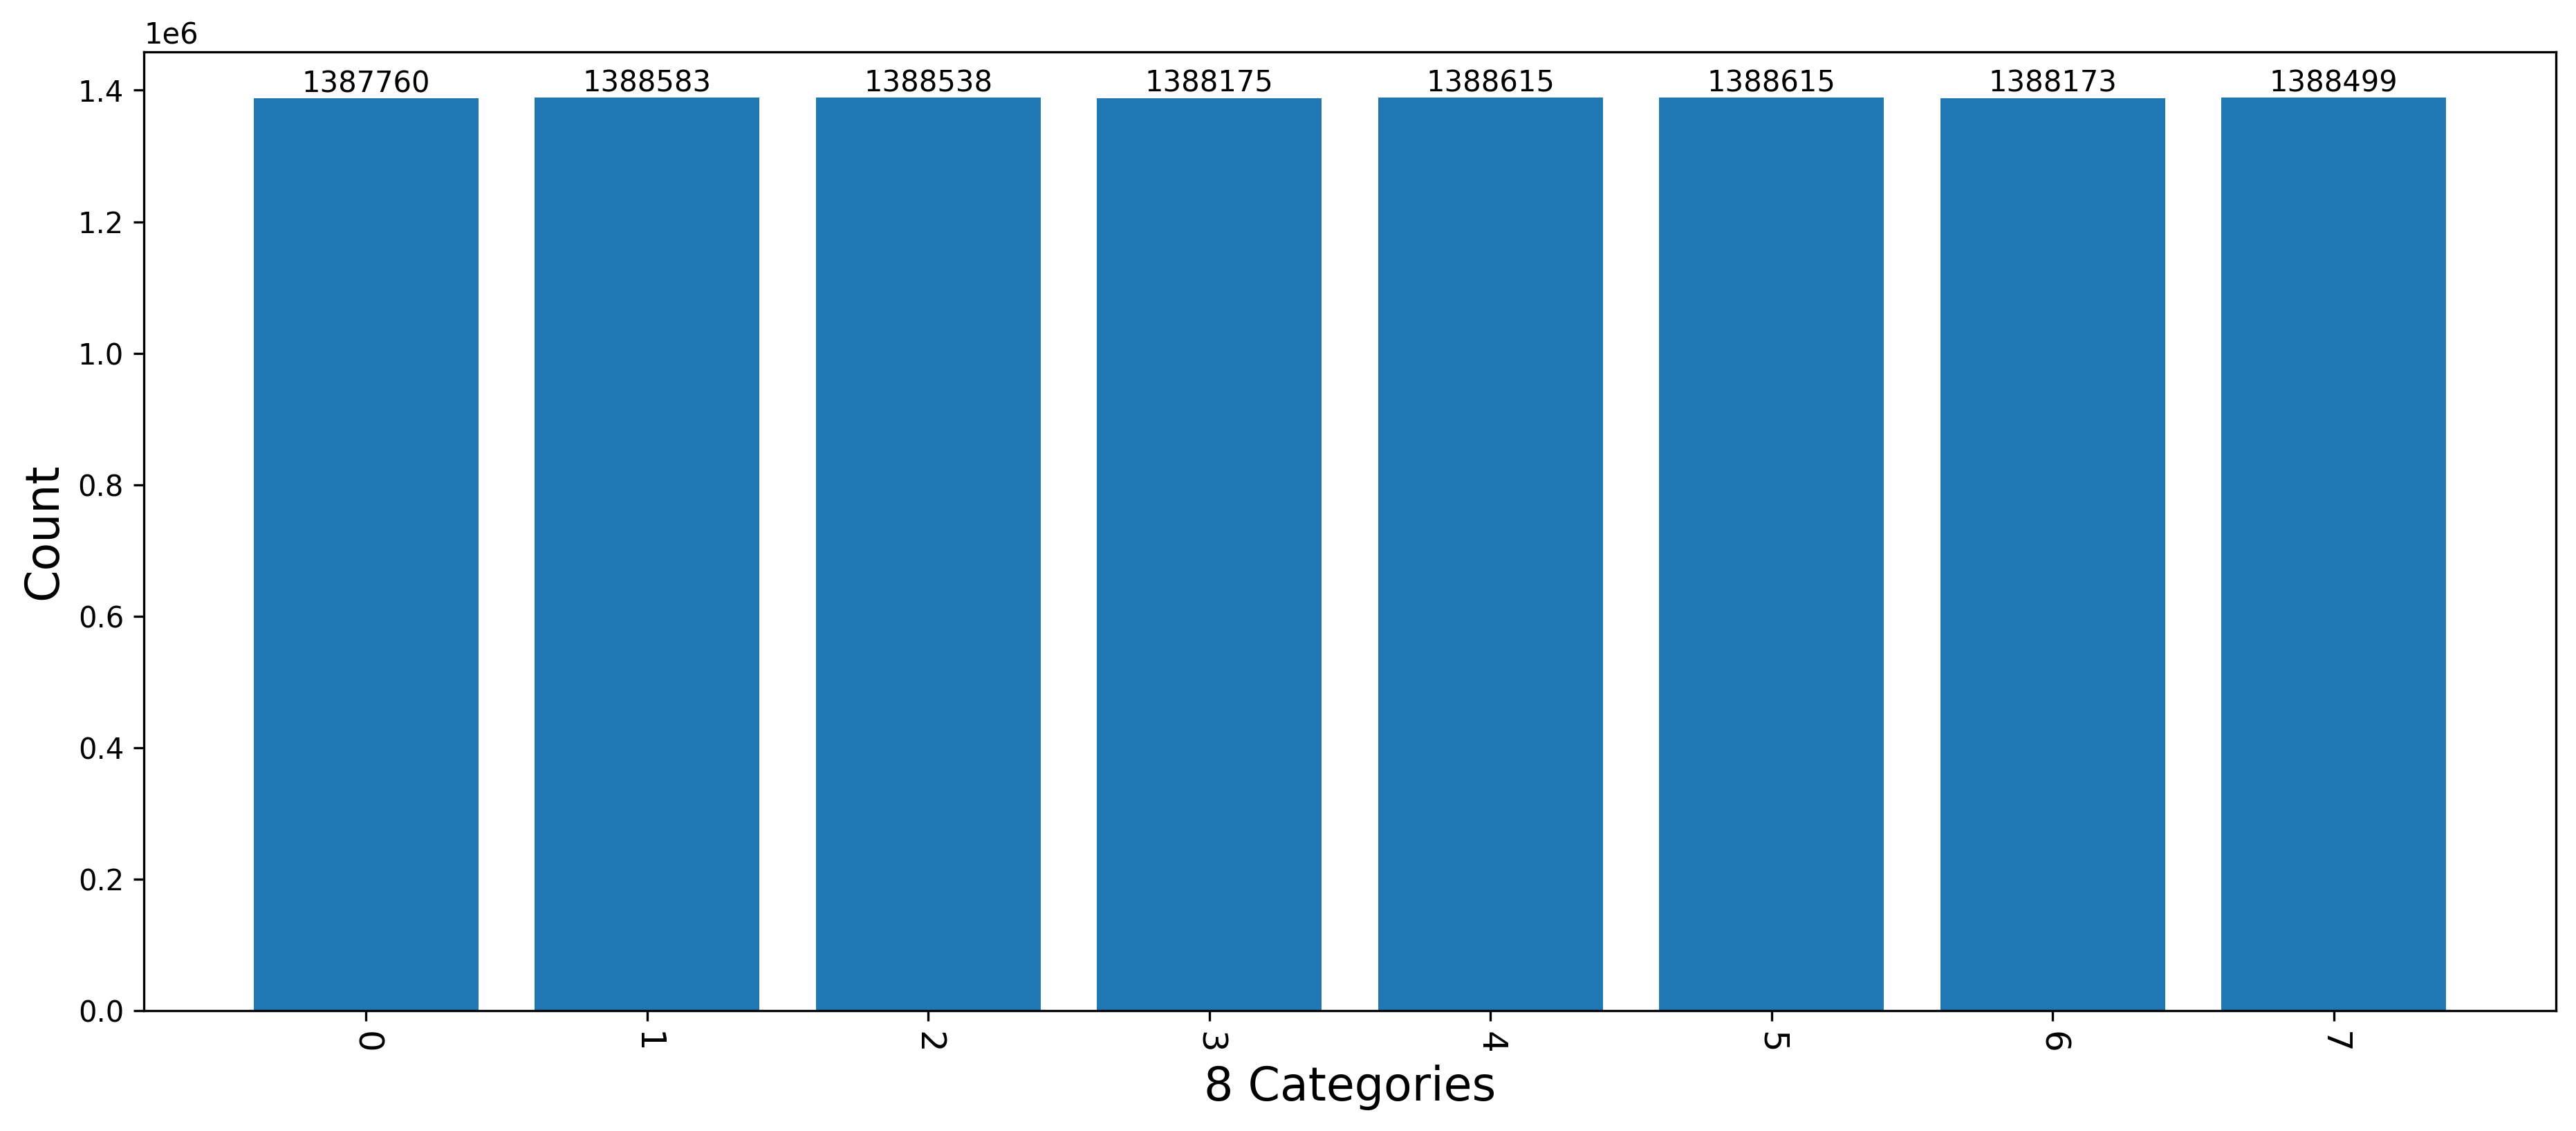

In [121]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_smote,values_smote)
for x_smote,y_smote in zip(labels_smote,values_smote):
    plt.text(x_smote,y_smote,y_smote,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [122]:
#4. Training
clf=RandomForestClassifier(bootstrap=True,random_state=12345,n_jobs=-1)

In [123]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Time of Training : 506.899 s


In [124]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

In [125]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [126]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [127]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [128]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [129]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [130]:
y_test_en,y_pred_test_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [131]:
#5. Result 
#5.1 Train
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_train_en,y_pred_train_en,average='macro'))

==Train==
[[1387431       0       0      50       0       0     279       0]
 [      0 1388583       0       0       0       0       0       0]
 [      0       0 1388538       0       0       0       0       0]
 [     19       0       0 1388156       0       0       0       0]
 [      0       0       0       0 1388615       0       0       0]
 [      0       0       0       0       0 1388615       0       0]
 [      3       0       0       0       0       0 1388169       1]
 [      0       0       0       0       0       0       0 1388499]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1387760
           1       1.00      1.00      1.00   1388583
           2       1.00      1.00      1.00   1388538
           3       1.00      1.00      1.00   1388175
           4       1.00      1.00      1.00   1388615
           5       1.00      1.00      1.00   1388615
           6       1.00      1.00      1.00   1388173
           7       1

In [132]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 0.9999683081542219
Weighted Precision : 0.9999683127917561
Weighted Recall    : 0.9999683081542219
Weighted F1-score  : 0.999968307702752


In [133]:
#5.2 Test
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[683039    287      0    183      0      0    348      4]
 [    61    594      0      0      0      0      0      0]
 [     2      0   3047      0      0      0      0      1]
 [   138      0      0 106144      0      0     10      0]
 [     0      0      0      0      1      0      0      0]
 [     4      0      0      0      0     12      0      0]
 [    85      0      0      6      0      0  29741      2]
 [    15      0      0      1      0      0      0    687]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    683861
           1       0.67      0.91      0.77       655
           2       1.00      1.00      1.00      3050
           3       1.00      1.00      1.00    106292
           4       1.00      1.00      1.00         1
           5       1.00      0.75      0.86        16
           6       0.99      1.00      0.99     29834
           7       0.99      0.98      0.98       703

    accuracy                  

In [134]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9986087053560598
Weighted Precision : 0.9987015334577637
Weighted Recall    : 0.9986087053560598
Weighted F1-score  : 0.9986403138153169


### Random Forest With Original Data   
Accuracy Score =  0.9103102912538195   
Precison       =  0.9684073872067926   
Recall         =  0.9103102912538195   
F1_score       =  0.9340837954082126   
Auc score      =  0.9548073632993797   

### Weight Metrics   
Accuracy Score     : 0.9985189444112895   
Weighted Precision : 0.99850615428196   
Weighted Recall    : 0.9985189444112895   
Weighted F1-score  : 0.9985091535241425   

### Random Forest With SMOTE   
Accuracy Score =  0.9563704217494868   
Precison       =  0.9549066052533266   
Recall         =  0.9563704217494868   
F1_score       =  0.9506837090876916   
Auc score      =  0.9779754647818648

### RandomForest With SMOTETomek   
Accuracy Score =  0.9534269228177952   
Precison       =  0.9562525162322424   
Recall         =  0.9534269228177952   
F1_score       =  0.9504606794982864   
Auc score      =  0.976510832281807   

### Weight Metrics After SMOTE   
Accuracy Score     : 0.9985759547410761   
Weighted Precision : 0.998684046700059   
Weighted Recall    : 0.9985759547410761   
Weighted F1-score  : 0.9986116272645491   

### Weight Metrics After SMOTETomek
Accuracy Score     : 0.9986087053560598
Weighted Precision : 0.9987015334577637
Weighted Recall    : 0.9986087053560598
Weighted F1-score  : 0.9986403138153169